In [1]:
import geopandas as gpd
from pyproj import Proj, transform
from shapely.geometry import Point
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
place = "glasgow"
local_crs = 27700
latlng = (-4.251846930489373, 55.86421405612109)

In [3]:
buildings = gpd.read_parquet(f"./output/{place}/buildings_morphometric_var.pq")
tessellation = gpd.read_parquet(f"./output/{place}/tessellation_morphometric_var.pq")
# streets = gpd.read_parquet(f"output/{place}/--PST processed file--")
stroke = gpd.read_parquet(f"output/{place}/stroke_gdf.pq")

In [4]:
buildings_merged = buildings.merge(tessellation.drop(columns=['geometry']), on='uID', how='inner')
buildings_merged_centroids = buildings_merged
buildings_merged_centroids["geometry"] = buildings_merged_centroids['geometry'].centroid

In [5]:
# Your latitude and longitude tuple (latitude, longitude)

# Transform the coordinates
x_centre, y_centre = transform(4326, local_crs, latlng[1], latlng[0])
centre_point = Point(x_centre, y_centre)

/tmp/ipykernel_27961/1855496908.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_centre, y_centre = transform(4326, local_crs, latlng[1], latlng[0])


In [6]:
buildings_merged_centroids['distance_to_centre'] = buildings_merged_centroids['geometry'].distance(centre_point)

In [7]:
buildings_merged = buildings_merged_centroids.drop(columns=["uID", "geometry"])

In [8]:
buildings_merged = buildings_merged.dropna()

In [9]:
# Response variable
y = buildings_merged['distance_to_centre']

# Feature variables (excluding the response variable)
X = buildings_merged.drop(columns=['distance_to_centre'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize and fit the Linear Regression model
model = LinearRegression()
model.fit(X_scaled, y)

# Coefficients and Intercept
coefficients = model.coef_
intercept = model.intercept_

# Predictions
predictions = model.predict(X_scaled)

# Number of observations and number of features
n = len(y)
p = X.shape[1]

# Residual Sum of Squares and Total Sum of Squares
rss = np.sum((y - predictions) ** 2)
tss = np.sum((y - np.mean(y)) ** 2)

# R-squared and Adjusted R-squared
r_squared = 1 - (rss / tss)
adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))

# Standard Error of the coefficients
mse = rss / (n - p - 1)
se = np.sqrt(np.diagonal(mse * np.linalg.inv(np.dot(X_scaled.T, X_scaled))))

# t-statistics and p-values for coefficients
t_stats = coefficients / se
p_values = [2 * (1 - stats.t.cdf(np.abs(t), n - p - 1)) for t in t_stats]

# F-statistic
f_statistic = (r_squared / p) / ((1 - r_squared) / (n - p - 1))

def get_significance_asterisks(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Coefficient': coefficients,
    'Standard Error': se,
    't value': t_stats,
    'p value': p_values,
    'Significance': [get_significance_asterisks(p) for p in p_values]
}, index=X.columns)
summary_df.loc['Intercept'] = [intercept, np.nan, np.nan, np.nan, '']

# Print summary statistics
print(f"Number of Observations: {n}")
print(f"R-squared: {r_squared}")
print(f"Adjusted R-squared: {adjusted_r_squared}")
print(f"F-statistic: {f_statistic}\n")
print(summary_df)

Number of Observations: 475020
R-squared: 0.08182021285552943
Adjusted R-squared: 0.0817738201253081
F-statistic: 1763.6429773637358

                                                     Coefficient  \
building_area                                        -291.562101   
building_circular_compactness                        -106.857379   
building_elongation                                  -183.906463   
building_squareness                                    18.451291   
building_eri                                          -59.850798   
building_orientation                                  -48.713484   
building_neighbour_dist                               154.703845   
building_neighbourhood_interbuilding_distance       -1492.731096   
building_circular_compactness_weight                 3377.981946   
building_elongation_weight                          -2854.081381   
building_squareness_weight                           -607.364932   
building_eri_weight                               

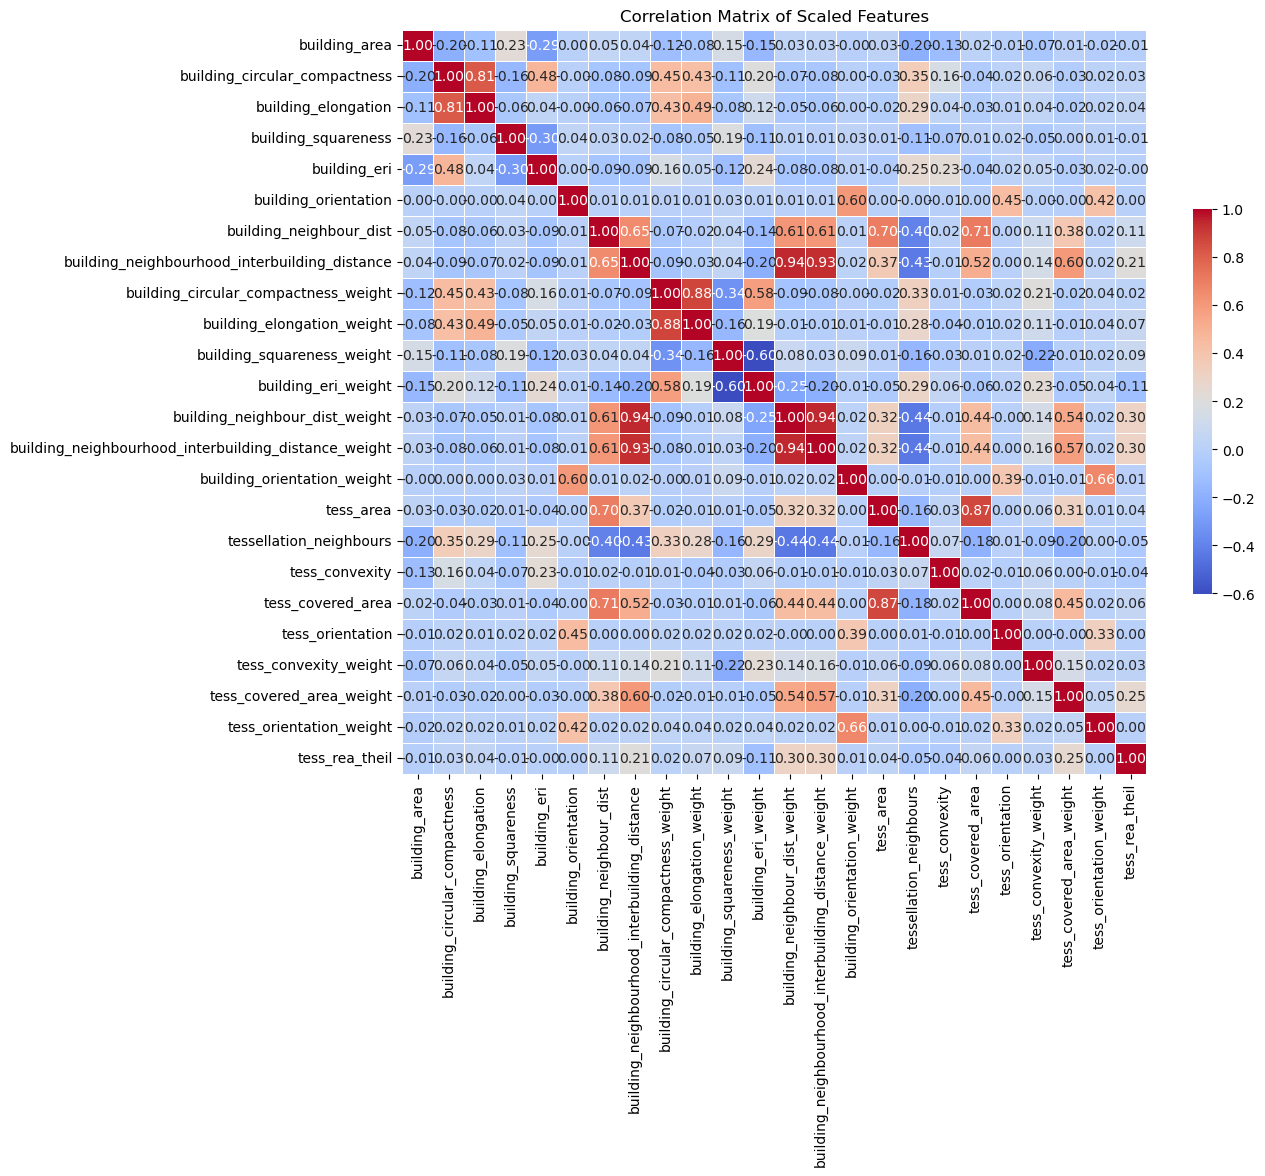

In [11]:
# Convert the numpy array back to a pandas DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Calculate the correlation matrix
corr_matrix = X_scaled_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Adding title
plt.title('Correlation Matrix of Scaled Features')

# Show the plot
plt.show()

In [12]:
residuals = y - predictions

In [13]:
# Creating a residual plot with Seaborn
plt.figure(figsize=(10, 6))
sns.residplot(x=predictions, y=residuals, lowess=True, scatter_kws={'alpha': 0.05, 's': 10}, line_kws={'color': 'red'})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Seaborn Residual Plot')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.show()